In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
houseSales = pd.read_csv('sample_data/new_one_family_houses.csv') # U.S. Census Bureau and U.S. Department of Housing and Urban Development, 
                                                      # New One Family Houses Sold: United States [HSN1F], 
                                                      # retrieved from FRED, Federal Reserve Bank of St. Louis; 
                                                      # https://fred.stlouisfed.org/series/HSN1F, March 3
scaler = MinMaxScaler()
scaler.fit(houseSales.Sales.values.reshape(-1, 1))
houseSalesScaled = scaler.transform(houseSales.Sales.values.reshape(-1, 1))
houseSales['HouseSalesScaled'] = houseSalesScaled

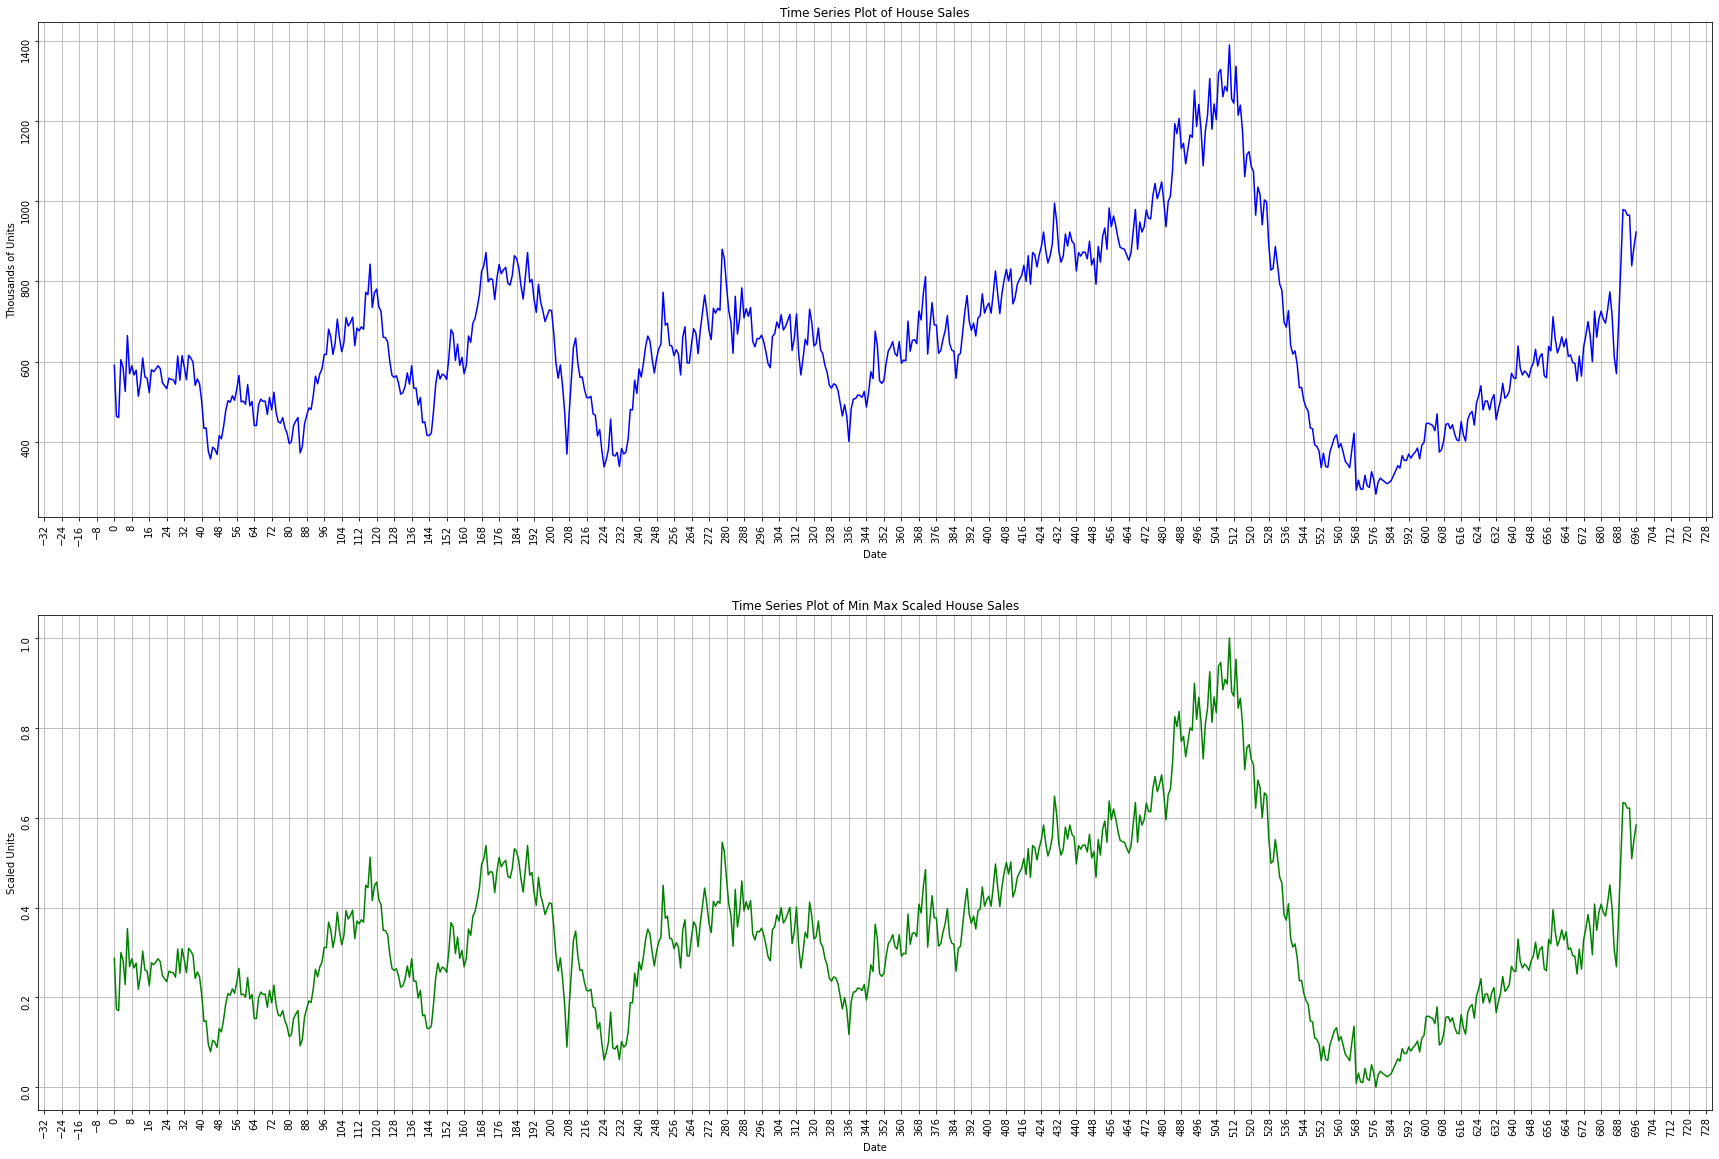

In [5]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(20)
fig.set_figwidth(30)
fig.tight_layout(pad=15)

M = 100
xticks = ticker.MaxNLocator(M)

ax1 = fig.add_subplot(gs[0,0])
ax1.plot(houseSales.index, houseSales.Sales, 'b-')
ax1.xaxis.set_major_locator(xticks)
ax1.tick_params(labelrotation=90)
ax1.set_xlabel('Date')
ax1.set_ylabel('Thousands of Units')
ax1.title.set_text('Time Series Plot of House Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1,0])
ax2.plot(houseSales.index, houseSales.HouseSalesScaled, 'g-')
ax2.xaxis.set_major_locator(xticks)
ax2.tick_params(labelrotation=90)
ax2.set_xlabel('Date')
ax2.set_ylabel('Scaled Units')
ax2.title.set_text('Time Series Plot of Min Max Scaled House Sales')
ax2.grid(True)

plt.savefig('image1.png')
plt.show()

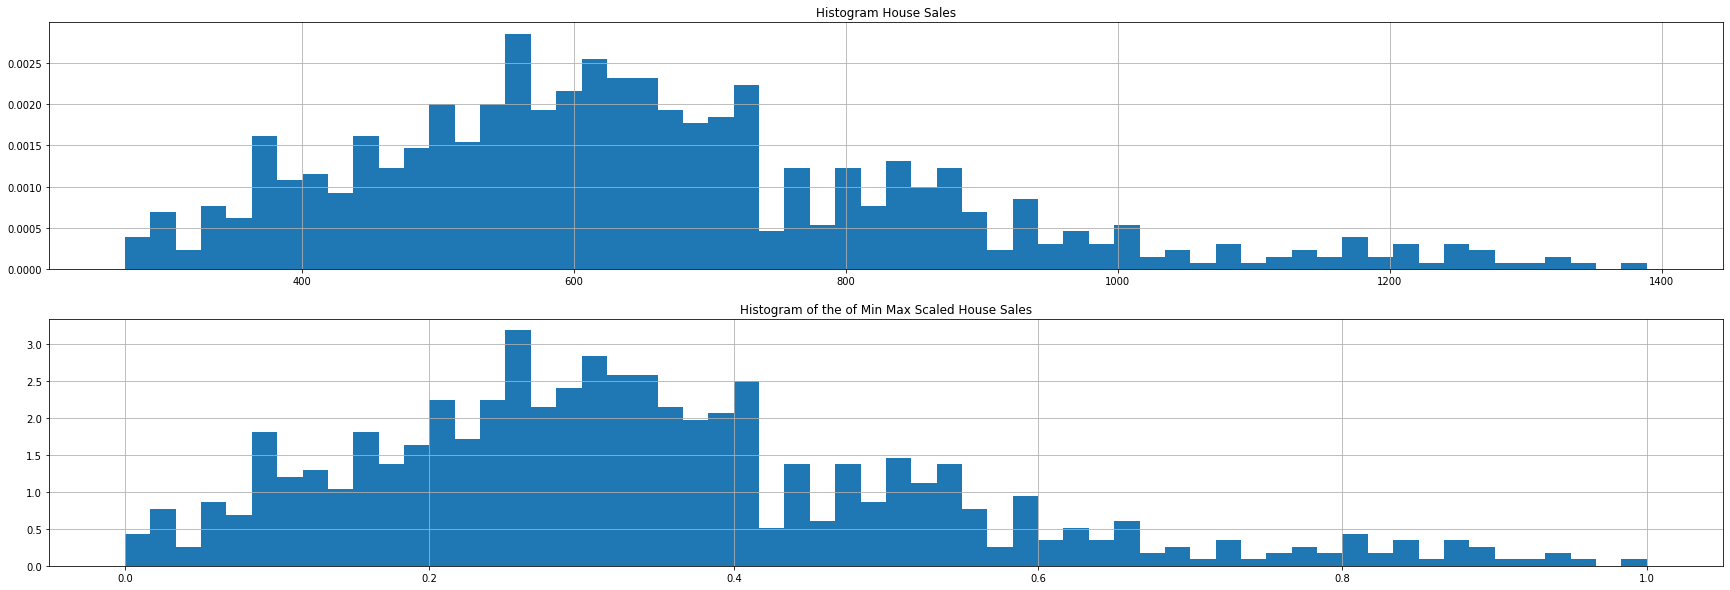

In [6]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(10)
fig.set_figwidth(30)
fig.tight_layout(pad=6)

ax1 = fig.add_subplot(gs[0,0])
ax1.hist(houseSales.Sales, density=True, bins=60)
ax1.title.set_text('Histogram House Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1,0])
ax2.hist(houseSales.HouseSalesScaled, density=True, bins=60)
ax2.title.set_text('Histogram of the of Min Max Scaled House Sales')
ax2.grid(True)

plt.savefig('image2.png')
plt.show()

In [7]:
result = adfuller(houseSales.Sales.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -2.8085520725549897
p-value: 0.05706251126952963
Critial Values:
   1%, -3.4400605106273368
Critial Values:
   5%, -2.865824986587412
Critial Values:
   10%, -2.5690518865761


In [8]:
result = adfuller(houseSales.HouseSalesScaled.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -2.808552072555019
p-value: 0.057062511269525495
Critial Values:
   1%, -3.4400605106273368
Critial Values:
   5%, -2.865824986587412
Critial Values:
   10%, -2.5690518865761


In [10]:
acfSalesScaled = acf(houseSales.HouseSalesScaled, fft=True, nlags=40)
acfSalesScaledNp = np.array(acfSalesScaled)

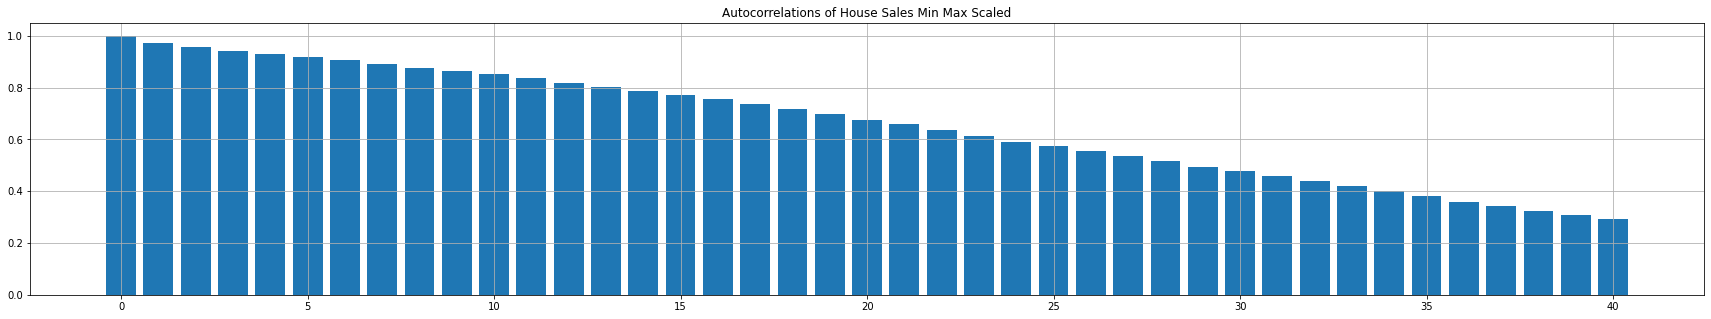

In [11]:
plt.figure(figsize=(30, 5))
plt.title("Autocorrelations of House Sales Min Max Scaled")
plt.bar(range(len(acfSalesScaledNp)), acfSalesScaledNp)
plt.grid(True)

plt.savefig('image3.png')
plt.show()

In [13]:
pacfSalesScaled = pacf(houseSales.HouseSalesScaled, nlags=40)
pacfSalesScaledNp = np.array(pacfSalesScaled)

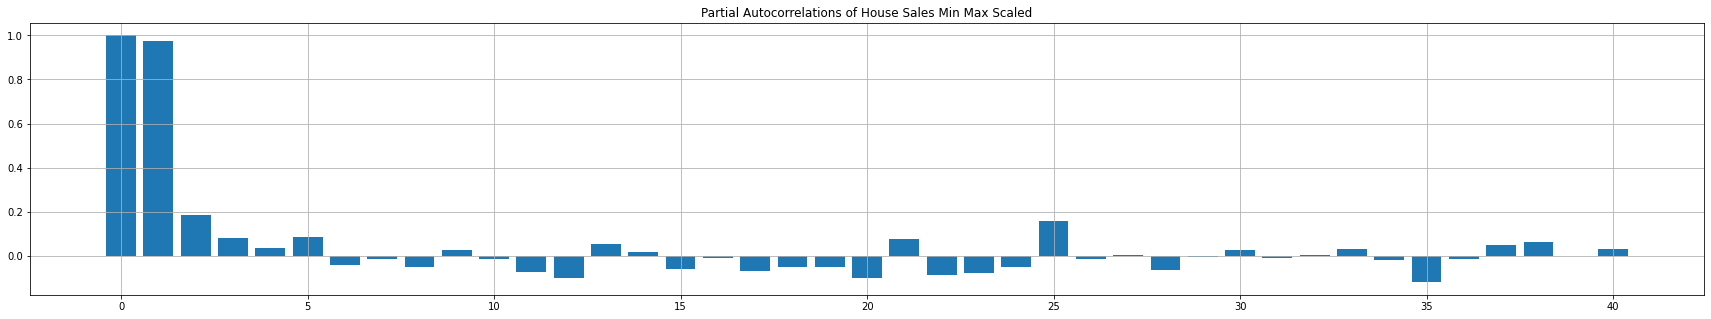

In [14]:
plt.figure(figsize=(30, 5))
plt.title("Partial Autocorrelations of House Sales Min Max Scaled")
plt.bar(range(len(pacfSalesScaledNp)), pacfSalesScaledNp)
plt.grid(True)
plt.savefig('image4.png')

In [15]:
SIZE = len(houseSales.HouseSalesScaled)
WINDOW_SIZE = 48
BATCH_SIZE= SIZE-WINDOW_SIZE*2
EPOCHS = 200

In [16]:
DateTrain = houseSales.index.values[0:BATCH_SIZE]
DateValid = houseSales.index.values[BATCH_SIZE:]
XTrain = houseSales.HouseSalesScaled.values[0:BATCH_SIZE].astype('float32')
XValid = houseSales.HouseSalesScaled.values[BATCH_SIZE:].astype('float32')

# Obtain shapes for vectors of size (,1) for dates series

DateTrain = np.reshape(DateTrain, (-1, 1))
DateValid = np.reshape(DateValid, (-1, 1))

print("Shape of the training set date series: ", DateTrain.shape)
print("Shape of the validation set date series: ", DateValid.shape)
print()
print("Shape of the training set logarithm of sales series: ", XTrain.shape)
print("Shape of the validation set logarithm of sales series in a stateless LSTM: ", XValid.shape)

Shape of the training set date series:  (601, 1)
Shape of the validation set date series:  (96, 1)

Shape of the training set logarithm of sales series:  (601,)
Shape of the validation set logarithm of sales series in a stateless LSTM:  (96,)


In [17]:
tf.random.set_seed(1234)

def windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE): 
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) 
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset
  
DatasetTrain = windowed_dataset(XTrain)
DatasetVal = windowed_dataset(XValid)

## LSTM Estimation and Forecasting.

In [18]:
model_2 = tf.keras.models.Sequential([
tf.keras.layers.LSTM(8, input_shape=[None, 1], return_sequences=True),
tf.keras.layers.LSTM(4, input_shape=[None, 1]),
tf.keras.layers.Dense(1)
])
model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 8)           320       
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 533
Trainable params: 533
Non-trainable params: 0
_________________________________________________________________


In [19]:
optimizer = tf.keras.optimizers.Adam()
model_2.compile(loss='huber_loss', optimizer=optimizer)
history = model_2.fit(DatasetTrain, epochs=EPOCHS, validation_data=DatasetVal, verbose=1)

Epoch 1/200
1/1 [==============================] - 4s 4s/step - loss: 0.1456 - val_loss: 0.1189
Epoch 2/200
1/1 [==============================] - 0s 157ms/step - loss: 0.1408 - val_loss: 0.1146
Epoch 3/200
1/1 [==============================] - 0s 162ms/step - loss: 0.1362 - val_loss: 0.1104
Epoch 4/200
1/1 [==============================] - 0s 174ms/step - loss: 0.1316 - val_loss: 0.1063
Epoch 5/200
1/1 [==============================] - 0s 166ms/step - loss: 0.1272 - val_loss: 0.1024
Epoch 6/200
1/1 [==============================] - 0s 162ms/step - loss: 0.1230 - val_loss: 0.0986
Epoch 7/200
1/1 [==============================] - 0s 156ms/step - loss: 0.1189 - val_loss: 0.0949
Epoch 8/200
1/1 [==============================] - 0s 168ms/step - loss: 0.1149 - val_loss: 0.0913
Epoch 9/200
1/1 [==============================] - 0s 165ms/step - loss: 0.1110 - val_loss: 0.0879
Epoch 10/200
1/1 [==============================] - 0s 159ms/step - loss: 0.1073 - val_loss: 0.0845
Epoch 11/200

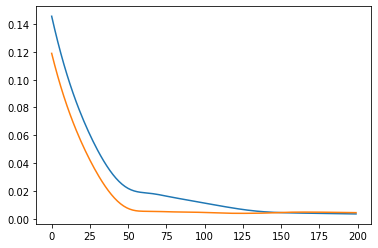

In [20]:
fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [21]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True) 
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(SIZE).prefetch(1)
  forecast = model.predict(ds)
  return forecast

Forecast = model_forecast(model_2, houseSales.HouseSalesScaled.values[:, np.newaxis], WINDOW_SIZE)
Results = Forecast[BATCH_SIZE-WINDOW_SIZE:-1]
Results1 = scaler.inverse_transform(Results.reshape(-1,1))
XValid1 = scaler.inverse_transform(XValid.reshape(-1,1))

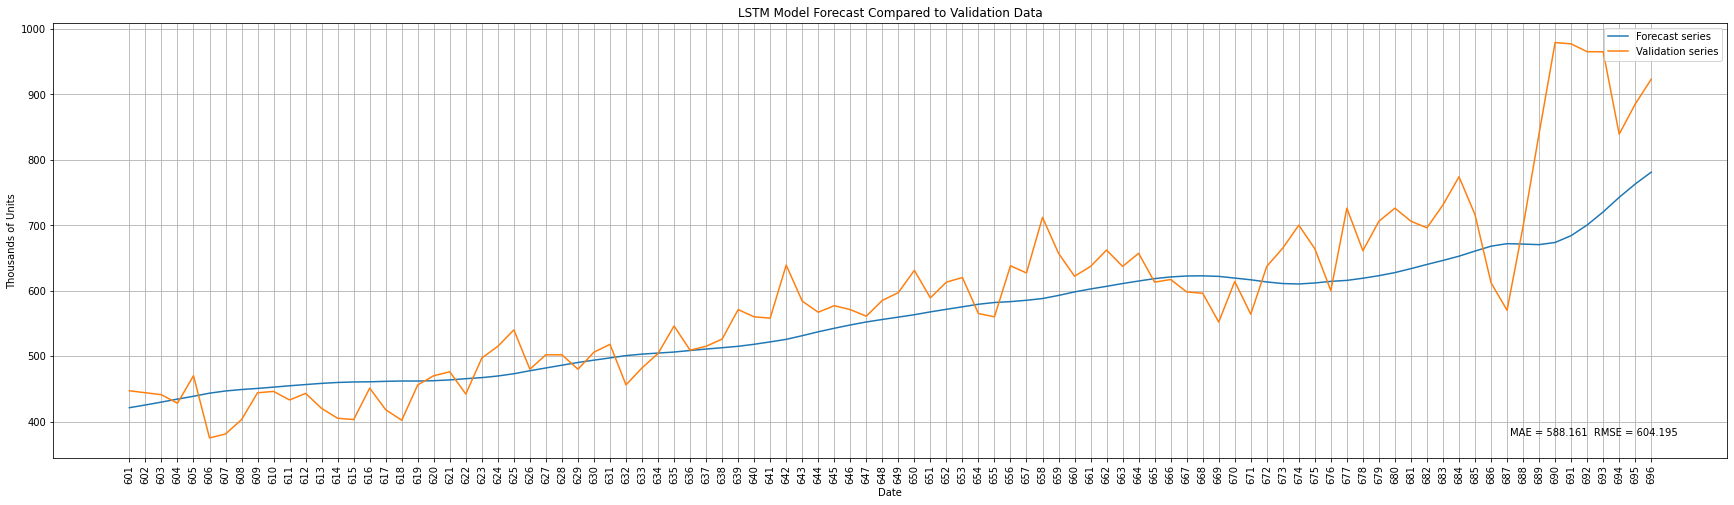

In [22]:
plt.figure(figsize=(30, 8))
plt.title("LSTM Model Forecast Compared to Validation Data")
plt.plot(DateValid, Results1, label='Forecast series')
plt.plot(DateValid, np.reshape(XValid1, (2*WINDOW_SIZE, 1)), label='Validation series')
plt.xlabel('Date')
plt.ylabel('Thousands of Units')
plt.xticks(DateValid[:,-1], rotation = 90) 
plt.legend(loc="upper right")

MAE = tf.keras.metrics.mean_absolute_error(XValid1[:,-1], Results[:,-1]).numpy()
RMSE = np.sqrt(tf.keras.metrics.mean_squared_error(XValid1[:,-1], Results[:,-1]).numpy())

textstr = "MAE = " + "{:.3f}".format(MAE) + "  RMSE = " + "{:.3f}".format(RMSE)

# place a text box in upper left in axes coords
plt.annotate(textstr, xy=(0.87, 0.05), xycoords='axes fraction')
plt.grid(True)

plt.savefig('image5.png')
plt.show()

In [23]:
print(MAE)
print(RMSE)

588.1609
604.19543
